In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
from collections import Counter
import networkx
import networkx.algorithms.community as nxcom
import plotly.graph_objects as go
import math
%matplotlib inline
plt.style.use("ggplot")

In [23]:
%%time
df = pd.read_pickle('./data/data.pkl')
df.head()

Wall time: 565 ms


,Affiliations,Author(s) ID,Authors,Authors with affiliations,Cited by,Document Type,Source,Source title,Title,Year
0,"Systems' Architecture Team, Ensem, Hassan II U...",36701835800;24725091300;,"Moutaouakkil F., Medromi H.","Moutaouakkil, F., Systems' Architecture Team, ...",1.0,Conference Paper,Scopus,ICCTD 2010 - 2010 2nd International Conference...,Control robot by multiagent control architecture,2010
1,"Laboratoire de Chimie Physique Générale, Facul...",36911796000;24823985800;6602908622;7004122780;...,"Saoiabi S., El Asri S., Laghzizil A., Coradin ...","Saoiabi, S., Laboratoire de Chimie Physique Gé...",18.0,Article,Scopus,Materials Letters,Nanoporous surface of organofunctionalized hyd...,2010
2,"University Caddy Ayyad, Bd. Prince My Abdellah...",6602701872;35760797400;35760820700;7006304181;,"Mesquine F., Bakka O., El Bahja H., Vega P.","Mesquine, F., University Caddy Ayyad, Bd. Prin...",5.0,Conference Paper,Scopus,Proceedings of the 15th IEEE International Con...,Observer based regulator problem for WWTP with...,2010
3,"Mohammed V University, Engineering Mohammedia ...",36696079100;55944424900;55935818600;,"El Alem W., El Hami A., Ellaia R.","El Alem, W., Mohammed V University, Engineerin...",1.0,Conference Paper,Scopus,Key Engineering Materials,Structural shape optimization using an adaptiv...,2010
4,"ENSIETA, LBMS, Mechanics of Naval and Offshore...",55923106700;23092984100;7003567324;,"Tarfaoui M., Choukri S., Neme A.","Tarfaoui, M., ENSIETA, LBMS, Mechanics of Nava...",6.0,Conference Paper,Scopus,Key Engineering Materials,Dynamic response of symmetric and asymmetric E...,2010


In [3]:
df.shape

(22000, 10)

In [26]:
def replace_countries(row):
    text = row[3]
    for country in pycountry.countries:
        if country.name in text:
            return text.replace(country.name, country.alpha_3)
        else:
            return text
def auth_count_per_paper(row):
    auths = row[1]
    return len(auths.split(';')) - 1
def is_inter(row):
    aff = row[0]
    affs = aff.split(';')
    countries = list()
    for a in affs:
        countries.append(a.split(',')[-1].strip())
    return len(set(countries)) > 1
        
df['Authors with affiliations'] = df.apply(replace_countries, axis=1)
df['Authors Per Paper'] = df.apply(auth_count_per_paper, axis=1)
df['is_international'] = df.apply(is_inter, axis=1)
df.head(1)

,Affiliations,Author(s) ID,Authors,Authors with affiliations,Cited by,Document Type,Source,Source title,Title,Year,Authors Per Paper,is_international
0,"Systems' Architecture Team, Ensem, Hassan II U...",36701835800;24725091300;,"Moutaouakkil F., Medromi H.","Moutaouakkil, F., Systems' Architecture Team, ...",1.0,Conference Paper,Scopus,ICCTD 2010 - 2010 2nd International Conference...,Control robot by multiagent control architecture,2010,2,False


In [27]:
def get_contries(affiliations):
    n = len(affiliations)
    contries = list()
    for i in range(n):
        aff_tmp = affiliations[i].split(';')
        words = list()
        for a in aff_tmp:
            words.append(a.split(',')[-1].strip())
        contries.append(set(words))
    return contries

"""
calculate histogram for {number of affiliations for a document(paper, conference paper, book chapter): number of documets}
param: 

"""
def get_counts(affiliations):
    contries = get_contries(affiliations)
    counts = [len(contries[i]) for i in range(len(contries))]
    counter = Counter(counts)
    counter = dict(counter)
#     return pd.DataFrame(counter, columns={"N Affiliations", "N Documents"})
    return counter

"""
for each document calculate the number of affilliations then create the histogram of corresponding to affilliations number
param: dataframe
"""
def get_aff_doc(df):
    aff = df['Affiliations'].values
    counts = get_counts(aff)
    df_counts = pd.DataFrame([list(counts.keys()), list(counts.values())]).transpose()
    df_counts.columns = ['N Affilliations', 'N Documents']
    df_counts.sort_values(by="N Affilliations", inplace=True)
    return df_counts

"""
for each document calculate the number of affilliations then create the histogram of corresponding to affilliations number
param: dataframe
"""
def get_auth_doc(data):
    counter = Counter(data['Authors Per Paper'])
    counter = dict(counter)
    return counter

def get_coun_doc(data):
    countries = get_contries(data['Affiliations'].values)
    counts = [len(el) for el in countries]
    counter = Counter(counts)
    counter = dict(counter)
    return counter
    

# Histogram of Authors ====> Documents

In [ ]:
auth_occ = get_auth_doc(df)
auth_occ = pd.DataFrame([list(auth_occ.keys()), list(auth_occ.values())]).transpose()
auth_occ.columns = ['Authors', 'Documents']
auth_occ.sort_values(by='Authors', inplace=True)
auth_occ.reset_index(inplace=True, drop=True)
# remove outliers
auth_occ = auth_occ[auth_occ['Documents'] > 10]

In [ ]:
# With Outliers
average = df['Authors Per Paper'].sum()/df.shape[0]
average

In [ ]:
# Without Outliers
average = auth_occ['Authors'].dot(auth_occ['Documents'])/auth_occ['Documents'].sum()
average

In [ ]:
# Visualization
fig, ax = plt.subplots()
ax.axvline(math.floor(average), ls='--', color='k')
ax.text(4, 4000, "Average Number of\nAuthors per Publication", fontsize=10, verticalalignment="center")
auth_occ.plot(kind='bar', x='Authors', y='Documents', figsize=(10, 10), legend=False, ax=ax)
# auth_occ.plot(x='Authors', y='Documents', figsize=(10, 10), legend=False, color='green', ax=ax)
ax.set_title('Histogram of Number of Authors')
ax.set_xlabel("Authors")
ax.set_ylabel("Documents")
fig.savefig("./figures/auth_publ.png", dpi=100)

# Histogram of Countries ====> Documents

In [ ]:
coun_occ = get_coun_doc(df)
coun_occ = pd.DataFrame([list(coun_occ.keys()), list(coun_occ.values())]).transpose()
coun_occ.columns = ['Countries', 'Documents']
coun_occ.sort_values(by='Countries', inplace=True)
coun_occ.reset_index(inplace=True, drop=True)
# remove outliers
coun_occ = coun_occ[coun_occ['Countries'] <= 15]

In [ ]:
# With Outliers
def get_average_with_outliers(data):
    countries = get_contries(data['Authors with affiliations'].values)
    counts = [len(el) for el in countries]
    return sum(counts)/data.shape[0]
get_average_with_outliers(df)

In [ ]:
# Without Outliers (number of countries less than or equal 15)
average = coun_occ['Countries'].dot(coun_occ['Documents'])/coun_occ['Documents'].sum()
average

In [ ]:
# Visualization
fig, ax = plt.subplots()
# coun_occ.plot(kind='bar', x='Countries', figsize=(10, 10), legend=False, ax=ax)
ax.axvline(average, ls='--', color='k')
ax.text(1.7, 12_000, "Average Number of\nAuthors per Paper", fontsize=10, verticalalignment="center")
coun_occ.plot(x='Countries', figsize=(10, 10), legend=False, ax=ax)
ax.set_title('Histogram of Number of Countries')
ax.set_xlabel("Countries")
ax.set_ylabel("Documents")
plt.savefig("./figures/count_publ.png", dpi=100)

# Histogram of Affilliations ====> Documents

In [ ]:
df_counts = get_aff_doc(df)
df_counts.head()

In [ ]:
%%capture
df_pie = df_counts[df_counts["N Affilliations"] < 7]
df_pie.set_index(df_pie['N Affilliations'], inplace=True)
del df_pie['N Affilliations']
df_pie.loc['7 or more'] = sum(df_counts[df_counts["N Affilliations"] >= 7]["N Documents"].values)
df_pie.sort_values(by='N Documents', inplace=True, ascending=False)

In [ ]:
%%capture
df_pie.loc[:, "percentage"] = df_pie.loc[:, "N Documents"]/df_pie.loc[:, "N Documents"].sum()*100

In [ ]:
# Change index to add Affiliations in the legend
df_pie.set_index(map(lambda i: str(i) + " Affilliations", list(df_pie.index)), inplace=True)

In [ ]:
df_counts["N Affilliations"].dot(df_counts["N Documents"])/df_counts["N Documents"].sum()

In [ ]:
# Visualization
explode = (0, 0, 0.1, 0.2, 0.3, 0.4, 0.5) # to show the values clearly
ax = df_pie.plot.pie(y="percentage", autopct='%1.1f%%', shadow=True, 
                     startangle=90, explode=explode, figsize=(10, 10));
ax.set_xlabel("Histogram of Number of Affiliations per Publication", fontweight='bold')
ax.set_ylabel("")
plt.savefig("./figures/aff_publ.png", dpi=100)

# International collaboration over time

In [ ]:
group = df.groupby(by='Year')

In [ ]:
inter_puls = group['is_international'].sum()

In [ ]:
# some example data
threshold = inter_puls.sum()/inter_puls.shape[0]
values = np.array(inter_puls.values)
x = range(2010, 2010+inter_puls.shape[0])

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it
fig, ax = plt.subplots()

ax.bar(x, below_threshold, 0.35, color="g")
ax.bar(x, above_threshold, 0.35, color="r", bottom=below_threshold)

ax.text(2020.5, 800, "Average", fontsize=10,
            verticalalignment="center")

# horizontal line indicating the threshold
ax.axhline(threshold, ls='--', color='k')

ax.set_title("Progress of International Publications Over Time", fontweight='bold', pad=25)
ax.set_xlabel("Year")
ax.set_ylabel("Publications")

fig.savefig("./figures/inter_colla_prog_over_time.png", dpi=100)

In [7]:
def get_con(affiliations):
    n = len(affiliations)
    contries = list()
    for i in range(n):
        aff_tmp = affiliations[i].split(';')
        words = list()
        for a in aff_tmp:
            words.append(a.split(',')[-1])
        contries.append(words)
    return contries

def get_authors(data):
    corr = {}
    auth_ids = data['Author(s) ID']
    auth_na = data['Authors']
    auth_aff = data['Authors with affiliations']
    for k, v, a in zip(auth_ids, auth_na, auth_aff):
        ids = list(map(str.strip, k.split(';')))
        names = list(map(str.strip, v.split(',')))
        affs = a.split(';')
        auth_con = list()
        for af in affs:
            auth_con.append(af.split(',')[-1].strip())
        for i, n, t in zip(ids, names, auth_con):
            corr[i] = [n, t]
    return corr

# Co-author network

In [ ]:
networkx.__version__

* create graph network
* add nodes(author_id) and edges(co-author relation)
* 

## Full Co-Author Graph

In [ ]:
%%time
# # create author list
# #auth = get_authors(df)
# # create default network
# network = networkx.Graph()
# # add the all nodes (author_ids)
# #network.add_nodes_from(auth.keys())
# #for each document add (author --- author)
# k = 0
# for text in df['Author(s) ID']:
# #     if k == 100: break # temporary
#     k += 1
#     auths = text.split(';')[:-1] #remove the last null element
#     i = 0
#     for i in range(len(auths)):
#         for j in range(i+1, len(auths)):
#             if not network.has_node(auths[i]):
#                 network.add_node(auths[i].strip())
                
#             if not network.has_node(auths[j]):
#                 network.add_node(auths[j].strip())
                
#             if network.has_edge(auths[i], auths[j]):
#                 network[auths[i]][auths[j]]['weight'] += 1
#             else:
#                 network.add_edge(auths[i], auths[j], weight=1)

In [ ]:
# network.number_of_edges(), network.number_of_nodes()

In [ ]:
# networkx.draw(network)

In [ ]:
# sampling all documents having nb of authors less than 3
# indexs = np.random.permutation(np.arange(df.shape[0]))[:400]
# df_sample = df.iloc[indexs, :]
# df_sample.head()

In [ ]:
# # create author list
# #auth = get_authors(df)
# # create default network
# network = networkx.Graph()
# # add the all nodes (author_ids)
# #network.add_nodes_from(auth.keys())
# #for each document add (author --- author)
# k = 0
# for text in df_sample['Author(s) ID']:
#     k += 1
#     auths = text.split(';')[:-1] #remove the last null element
#     i = 0
#     for i in range(len(auths)):
#         for j in range(i+1, len(auths)):
#             if not network.has_node(auths[i]):
#                 network.add_node(auths[i].strip())
                
#             if not network.has_node(auths[j]):
#                 network.add_node(auths[j].strip())
                
#             if network.has_edge(auths[i], auths[j]):
#                 network[auths[i]][auths[j]]['weight'] += 1
#             else:
#                 network.add_edge(auths[i], auths[j], weight=1)

In [ ]:
# networkx.draw(network)

# Country === Nb Documents

In [ ]:
result = {}
for countries in get_contries(df['Affiliations']):
    for country in countries:
        if result.get(country) is not None:
            result[country] += 1
        else:
            result[country] = 1

In [ ]:
top_count = pd.DataFrame([result.keys(), result.values()]).transpose()
top_count.columns = ['Country', 'Documents']
top_count.sort_values(by='Documents', inplace=True, ascending=False)
top_count.reset_index(inplace=True, drop=True)

In [ ]:
top_count.iloc[1:30, :]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Choropleth(
    locationmode = "country names",
    locations = top_count['Country'],
    z = top_count['Documents'],
    text = top_count['Documents'],
    autocolorscale=True,
    reversescale=True,
    colorbar_title = 'Number of Publications',
    zmax = 4600,
    zmin = 1
))

fig.update_layout(
    title_text='International Collaboration Map',
    geo=dict(
        showcoastlines=True,
    ),
)
# plt.savefig("./figures/map_collaboration.png")
fig.write_html('./figures/inter_coll.html', auto_open=True) # to show interactive map in the browser
fig.write_image("./figures/inter_coll.png", scale=1.0)

# Moroccan Author ===== Nb Documents

* number of documents written by each author

In [8]:
authors = get_authors(df)
results = {}
for text in df['Author(s) ID']:
    authors_id = text.split(';')[:-1]  #woring with author id
    for author_id in authors_id:
        if authors[author_id][1] == "Morocco":
            if results.get(author_id) is not None: # already in result
                results[author_id] += 1
            else:
                results[author_id] = 1

In [ ]:
# len(results), results

In [9]:
top_auth = pd.DataFrame([results.keys(), results.values()]).transpose()
top_auth.columns = ['AuthorID', 'Documents']
top_auth.sort_values(by='Documents', inplace=True, ascending=False)
top_auth.reset_index(inplace=True, drop=True)

In [10]:
def add_name(row):
    return authors[row[0]][0]

top_auth['Author Name'] = top_auth.apply(add_name, axis=1)
top_10 = top_auth.iloc[1:10, :]
top_10 = top_10.iloc[::-1]
top_10

,AuthorID,Documents,Author Name
9,6506600233,311,Cherkaoui El Moursli R.
8,56073384700,323,Haddad N.
7,6506648426,386,Fassi F.
6,36491220300,412,Chafaq A.
5,7801537002,424,El Kacimi M.
4,8321315000,446,Ouchrif M.
3,35314645800,453,Derkaoui J.E.
2,35277955900,454,Goujdami D.
1,6603290513,460,Hoummada A.


In [11]:
average = top_auth.Documents.sum()/top_auth.shape[0]
average

3.4128262305913446

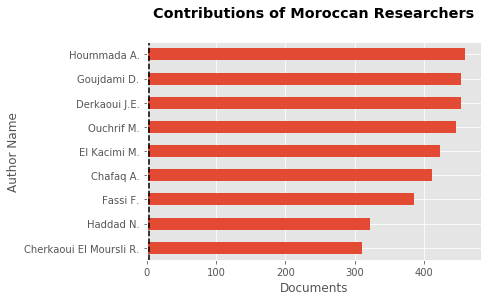

In [12]:
fig, ax = plt.subplots()
ax.axvline(average, ls='--', color='k')
# ax.text(4, 4000, "Average Number of\nAuthors per Publication", fontsize=10, verticalalignment="center")
top_10.plot(kind='barh', x='Author Name', y='Documents', legend=False, ax=ax)
ax.set_ylabel("Author Name")
ax.set_xlabel("Documents")
ax.set_title("Contributions of Moroccan Researchers", fontweight='bold', pad=25);
fig.savefig("./figures/top_10_auth.png", dpi=200)

# Network Part

## Co-author network

In [13]:
def get_co_authors(df, author_id):
    ca = dict()
    for text in df['Author(s) ID']:
        authors = text.split(";")[:-1]
        if author_id in authors:
            authors.remove(author_id)
            for author in authors:
                if ca.get(author) is not None:
                    ca[author] += 1
                else:
                    ca[author] = 1
    return ca

def get_network(df, author_id):
    network = networkx.Graph()
    network.add_node(author_id)
    co_authors = get_co_authors(df, author_id)
    for author in co_authors:
        network.add_node(author)
        network.add_edge(author, author_id)
        network[author][author_id]['weight'] = co_authors[author]
    return network

def draw_network(network, author_name):
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.set_title('Co-author Network for '+author_name, fontsize=20, fontweight='bold')
    sizes = [network[v][w]['weight']*10 for w, v in network.edges]
    pos = networkx.spring_layout(network)
    networkx.draw(network, pos, node_size=sizes, node_color='red', font_size=8, font_weight='bold')
    plt.tight_layout()
    plt.savefig("./figures/graph_{}.png".format(author_name), format="PNG")

In [14]:
df_sample = df[df['Authors Per Paper'] <= 1000] # eliminate publications with more than 1000 authors
df_sample.shape

(21543, 12)

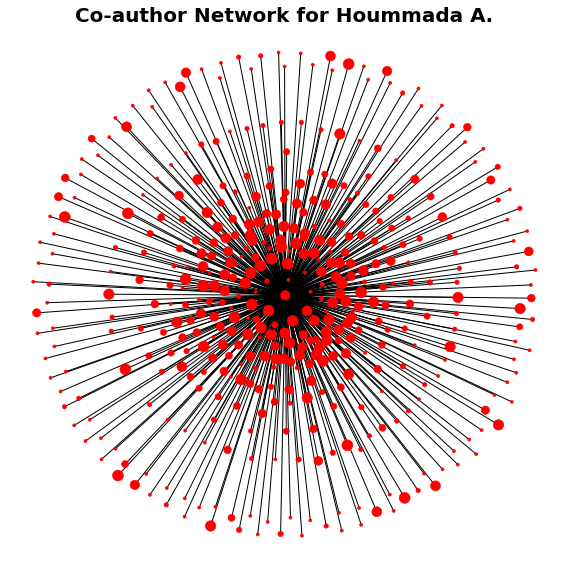

In [15]:
author_id = "6603290513"
author_name = top_auth[top_auth["AuthorID"] == author_id]["Author Name"].values[0]
network = get_network(df_sample, author_id)
draw_network(network, author_name)

In [16]:
networkx.density(network), network.number_of_nodes(), network.number_of_edges()

(0.004629629629629629, 432, 431)

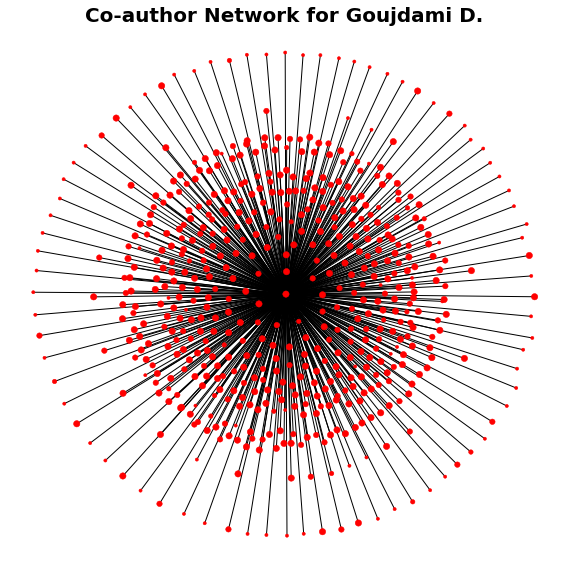

In [17]:
author_id = "35277955900"
author_name = top_auth[top_auth["AuthorID"] == author_id]["Author Name"].values[0]
network = get_network(df_sample, author_id)
draw_network(network, author_name)

In [18]:
networkx.density(network), network.number_of_nodes(), network.number_of_edges()

(0.0035460992907801418, 564, 563)

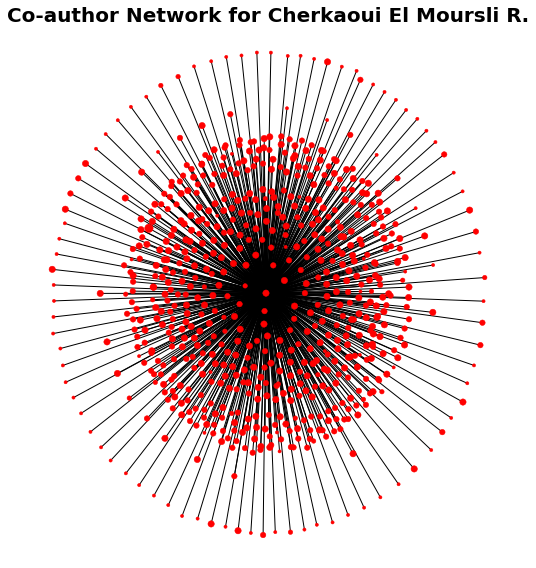

In [19]:
author_id = "6506600233"
author_name = top_auth[top_auth["AuthorID"] == author_id]["Author Name"].values[0]
network = get_network(df_sample, author_id)
draw_network(network, author_name)

In [20]:
networkx.density(network), network.number_of_nodes(), network.number_of_edges()

(0.0028776978417266188, 695, 694)

# Network of moroccan researchers (National Network)

In [ ]:
df.head(1)

In [ ]:
# # select only national (is_inter = False)
# df_nat = df[df['is_international'] == False]
# df_nat = df_nat[df_nat['num_authors'] <= 5]
# del df_nat['is_international']
# df_nat.head(1)

In [ ]:
df_nat.shape

In [ ]:
# len(dfn_list), dfn_list[0].shape

## network creation for each year (national publications)

In [30]:
def create_network(df, year=2010):
    df_ = df[df['Year'] == year]
    df_ = df_[df_['Authors Per Paper'] <= 100] # eliminate papers with more than 100 authors which are a few papaers but it influences greatly the result by creating a lot of edges
    # create author list
    #auth = get_authors(df)
    # create default network
    network = networkx.Graph()
    # add the all nodes (author_ids)
    #network.add_nodes_from(auth.keys())
    #for each document add (author --- author)
    # k = 0
    for text in df_['Author(s) ID']:
    #     if k == 100: break # temporary
    #     k += 1
        auths = text.split(';')[:-1] #remove the last null element
        i = 0
        for i in range(len(auths)):
            for j in range(i+1, len(auths)):
                if not network.has_node(auths[i]):
                    network.add_node(auths[i].strip())

                if not network.has_node(auths[j]):
                    network.add_node(auths[j].strip())

                if network.has_edge(auths[i], auths[j]):
                    network[auths[i]][auths[j]]['weight'] += 1
                else:
                    network.add_edge(auths[i], auths[j], weight=1)
    return network

### test (year = 2010)

In [ ]:
network = create_network(df_nat, 2010)

In [ ]:
networkx.density(network), network.number_of_nodes(), network.number_of_edges()

## show graph

In [21]:
# %%capture
# def draw_network(network):
    
#     fig = plt.figure(figsize=(25,25))
#     ax = plt.subplot(111)
#     ax.set_title('Graph - Shapes', fontsize=10)

#     pos = networkx.spring_layout(network, k=0.1)
#     sizes = [network[u][v]['weight']*10 for u, v in network.edges]
#     networkx.draw(network, pos, node_size=sizes, node_color='yellow', font_size=8, font_weight='bold', edge_size=1)

#     plt.tight_layout()
#     plt.savefig("Graph.png", format="PNG")
#     # plt.show()

### community detection

In [35]:
def get_communities(network):
    communities = sorted(nxcom.greedy_modularity_communities(network), key=len, reverse=True)
    return communities

In [36]:
def set_node_community(network, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            network.nodes[v]['community'] = c + 1

def set_edge_community(network):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in network.edges:
        if network.nodes[v].get('community') is not None and network.nodes[w].get('community') is not None:
            if network.nodes[v]['community'] == network.nodes[w]['community']:
                # Internal edge, mark with community
                network.edges[v, w]['community'] = network.nodes[v]['community']
            else:
                # External edge, mark as 0
                network.edges[v, w]['community'] = 0
                
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    if i >= 5:
        return 'yellow'
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [ ]:
communities = get_communities(network)
len(communities)

In [ ]:
def draw_network(network, year, is_nat):
    if is_nat:
        title = 'National Network of '
    else:
        title = 'International Network of '
    title += str(year)
    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    ax.set_title(title, fontsize=25, fontweight='bold')

    # plt.style.use('dark_background')

    #detect the communities
    communities = get_communities(network)
    
    # Set node and edge communities
    set_node_community(network, communities)
    set_edge_community(network)

    # Set community color for internal edges
    external = [(v, w) for v, w in network.edges if network.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in network.edges if network.edges[v, w]['community'] > 0]
    internal_color = ["black" for e in internal]
    node_color = [get_color(network.nodes[v]['community']) for v in network.nodes]
    
    pos = networkx.spring_layout(network)
    # external edges
    networkx.draw_networkx(
        network, 
        pos=pos, 
        node_size=10,
        edgelist=external, 
        edge_color="silver",
        node_color=node_color,
        alpha=0.5,
        with_labels=False)
    # internal edges
    networkx.draw_networkx(
        network, pos=pos, 
        edgelist=internal, 
        edge_color=internal_color,
        node_color=node_color,
        alpha=0.05, 
        with_labels=False)

    plt.tight_layout()
    plt.savefig("./figures/{}.png".format(title));

In [ ]:
draw_network(network, 2010, True)

In [ ]:
def len_communities(communities):
    lens = list()
    for com in communities:
        lens.append(len(com))
    return lens
lens = len_communities(communities)

# Countries Network

In [ ]:
# detect all (contry -- weight -- country)
countries = get_contries(df['Affiliations'])
cn = networkx.Graph()
for ec in countries:
    ec = list(ec)
    pairs = list()
    i = 0
    if len(ec) == 1:
        continue
    else:
        for i in range(len(ec)):
            for j in range(i+1, len(ec)):
                pairs.append((ec[i], ec[j]))
        for p in pairs:
            if cn.has_node(p[0]) and cn.has_node(p[1]):
                if not cn.has_edge(p[0], p[1]):
                    cn.add_edge(p[0], p[1])
                    cn[p[0]][p[1]]['weight'] = 1
                else:
                    cn[p[0]][p[1]]['weight'] += 1
            else:
                if not cn.has_node(p[0]):
                    cn.add_node(p[0])
                elif not cn.has_node(p[1]):
                    cn.add_node(p[1])
                else:
                    print("Error")
                    break
                cn.add_edge(p[0], p[1])
                cn[p[0]][p[1]]['weight'] = 1
                
cn.remove_node('Morocco'), cn.remove_node('');

In [ ]:
networkx.density(cn), cn.number_of_nodes(), cn.number_of_edges()

In [ ]:
def draw_countries_network(network):
    title = "Countries Network (excluding morocco)"
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.set_title(title, fontsize=25, fontweight='bold')

    # plt.style.use('dark_background')

    #detect the communities
    communities = get_communities(network)
    
    # Set node and edge communities
    set_node_community(network, communities)
    set_edge_community(network)

    # Set community color for internal edges
    external = [(v, w) for v, w in network.edges if network.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in network.edges if network.edges[v, w]['community'] > 0]
    internal_color = ["black" for e in internal]
    node_color = [get_color(network.nodes[v]['community']) for v in network.nodes]
    pos = networkx.spring_layout(network)
    # external edges
    networkx.draw_networkx(
        network, 
        pos=pos, 
        node_size=10,
        edgelist=external, 
        edge_color="silver",
        node_color=node_color,
        alpha=0.5,
        with_labels=False)
    # internal edges
    networkx.draw_networkx(
        network, pos=pos, 
        edgelist=internal, 
        edge_color=internal_color,
        node_color=node_color,
        alpha=0.05, 
        with_labels=False)

    plt.tight_layout()
    plt.savefig("./figures/{}.png".format(title))

In [ ]:
draw_countries_network(cn)

In [ ]:
communities = sorted(nxcom.greedy_modularity_communities(cn), key=len, reverse=True)
len(communities)

In [ ]:
nxcom.modularity(cn, communities)

# Algorithms

### degree of centrality, closeness, betweenness and PageRank

In [34]:
methods = ['degree', 'closeness', 'betweenness', 'pagerank']
def get_central_nodes(network, method='degree', n=10):
    if method == 1: centrality = networkx.degree_centrality(network)
    elif method == 2: centrality = networkx.closeness_centrality(network)
    elif method == 3: centrality = networkx.betweenness_centrality(network, normalized = True, endpoints = False) 
    elif method == 4: centrality = networkx.pagerank(network, alpha=0.85) 
    else: return None
    central_nodes = sorted(centrality, key=lambda k: centrality[k], reverse=True)
    return central_nodes[:n], centrality

In [ ]:
_, deg = get_central_nodes(cn, 1)

### centralization

In [ ]:
N=G.order()
degrees = dict(network.in_degree()).values()
max_in = max(indegrees)
centralization = float((N*max_in - sum(indegrees)))/(N-1)**2

In [33]:
def centralization(network):
    N = network.order()
    deg = dict(network.degree()).values()
    max_ = max(deg)
    centr = float((N*max_ - sum(deg)))/(N-1)**2
    return centr

centralization(cn)

In [ ]:
centralization(network)

### modularity

In [ ]:
nxcom.modularity(cn, communities)

# Build Networks

## National Networks 

### Build each year network and calculate the network mesures we defined before

In [28]:
def analyse(df, year, is_nat):
    # build network
    is_inter = not is_nat
    df = df[df['is_international'] == is_inter]
    network = create_network(df, year)
    communities = get_communities(network)
    mesures = {}
    # get calculated mesures and save clculated mesures in a dictionary
    mesures['authors'] = network.order()
    mesures['edges'] = network.number_of_edges()
    mesures['communities'] = len(communities)
    mesures['centralization'] = centralization(network)
    mesures['density'] = networkx.density(network)
    mesures['modularity'] = nxcom.modularity(network, communities)
    # save network figure
#     draw_network(network, year, is_nat)
    return mesures

In [37]:
years = list(range(2010, 2021))
is_nat = True
results = {}
for year in years:
    results[year] = analyse(df, year, is_nat)

In [38]:
authors = []
edges = []
communities = []
centralizations = []
density = []
modularities = []
for k in results.keys():
    v = results[k]
    authors.append(v['authors'])
    edges.append(v['edges'])
    communities.append(v['communities'])
    centralizations.append(v['centralization'])
    density.append(v['density'])
    modularities.append(v['modularity'])
years = list(results.keys())
df_mesures = pd.DataFrame([years, authors, edges, density, communities, centralizations, modularities]).transpose()
df_mesures.columns = ['Year', 'Authors', 'Edges', 'Density', 'Communities', 'Centralization', 'Modularity']
df_mesures

,Year,Authors,Edges,Density,Communities,Centralization,Modularity
0,2010.0,3110.0,11101.0,0.002296,285.0,0.023765,0.880119
1,2011.0,2958.0,9625.0,0.002201,321.0,0.021141,0.920913
2,2012.0,3083.0,9079.0,0.001911,346.0,0.024703,0.951247
3,2013.0,2968.0,8442.0,0.001917,369.0,0.026403,0.939488
4,2014.0,3695.0,12068.0,0.001768,346.0,0.019623,0.915539
5,2015.0,2893.0,7679.0,0.001836,417.0,0.011654,0.958989
6,2016.0,3365.0,8205.0,0.001450,503.0,0.015499,0.982610
7,2017.0,3315.0,8126.0,0.001479,514.0,0.012405,0.983467
8,2018.0,3443.0,8122.0,0.001371,538.0,0.010544,0.979421
9,2019.0,3419.0,8039.0,0.001376,569.0,0.010623,0.981763


## International Network

### Build each year network and calculate the network mesures we defined before

In [39]:
years = list(range(2010, 2021))
is_nat = False
results = {}
for year in years:
    results[year] = analyse(df, year, is_nat)

In [40]:
authors = []
edges = []
communities = []
centralization = []
density = []
for k in results.keys():
    v = results[k]
    authors.append(v['authors'])
    edges.append(v['edges'])
    communities.append(v['communities'])
    centralization.append(v['centralization'])
    density.append(v['density'])
years = list(results.keys())
df_mesures = pd.DataFrame([years, authors, edges, density, communities, centralization]).transpose()
df_mesures.columns = ['Year', 'Authors', 'Edges', 'Density', 'Communities', 'Centralization']
df_mesures

,Year,Authors,Edges,Density,Communities,Centralization
0,2010.0,3468.0,20051.0,0.003335,419.0,0.028689
1,2011.0,3610.0,16609.0,0.002550,411.0,0.018514
2,2012.0,3324.0,14807.0,0.002681,379.0,0.025012
3,2013.0,3850.0,18556.0,0.002504,416.0,0.028420
4,2014.0,3446.0,22651.0,0.003816,361.0,0.020863
5,2015.0,4614.0,35483.0,0.003334,429.0,0.019215
6,2016.0,3494.0,18052.0,0.002958,403.0,0.015941
7,2017.0,4329.0,38366.0,0.004095,409.0,0.021556
8,2018.0,4124.0,28987.0,0.003410,404.0,0.021577
9,2019.0,4796.0,46594.0,0.004052,429.0,0.017224
